In [2]:
from dask.distributed import Client
from dask_kubernetes import KubeCluster

cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=10, interval='2s')
client = Client(cluster)
client

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:    tcp://10.32.38.7:34069
distributed.scheduler - INFO -   dashboard at:                    :38927
distributed.scheduler - INFO - Receive client connection: Client-209e83dc-ad99-11ea-84b2-5a8b89141e3a
distributed.core - INFO - Starting established connection


<Client: 'tcp://10.32.38.7:34069' processes=0 threads=0, memory=0 B>

In [3]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs # A pythonic file-system interface to Google Cloud Storage
from tqdm.autonotebook import tqdm
import math
import copy
from scipy.interpolate import griddata
import seawater as sw
from mpl_toolkits.basemap import Basemap, cm, maskoceans

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

import warnings; warnings.simplefilter('ignore'); warnings.filterwarnings('ignore')

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


# Plotting average precipitation rate (1980-2000) for CMIP6 models, historical scenario

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

activity_id institution_id source_id experiment_id member_id table_id  \
0  AerChemMIP        AS-RCEC   TaiESM1       histSST  r1i1p1f1   AERmon   
1  AerChemMIP            BCC  BCC-ESM1       histSST  r1i1p1f1   AERmon   
2  AerChemMIP            BCC  BCC-ESM1       histSST  r1i1p1f1   AERmon   
3  AerChemMIP            BCC  BCC-ESM1       histSST  r1i1p1f1   AERmon   
4  AerChemMIP            BCC  BCC-ESM1       histSST  r1i1p1f1   AERmon   

  variable_id grid_label                                             zstore  \
0    od550aer         gn  gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...   
1       mmrbc         gn  gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...   
2     mmrdust         gn  gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...   
3       mmroa         gn  gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...   
4      mmrso4         gn  gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...   

   dcpp_init_year  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN

distributed.scheduler - INFO - Register tcp://10.32.4.14:33611
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.4.14:33611
distributed.core - INFO - Starting established connection


In [5]:
df['activity_id'].unique()

array(['AerChemMIP', 'C4MIP', 'CFMIP', 'CMIP', 'DAMIP', 'DCPP', 'FAFMIP',
       'GMMIP', 'HighResMIP', 'LS3MIP', 'LUMIP', 'OMIP', 'PMIP', 'RFMIP',
       'ScenarioMIP'], dtype=object)

In [6]:
df_pr_mon = df[(df.table_id == 'Amon') & (df.variable_id == 'pr') & (df.activity_id == 'CMIP') & (df.experiment_id == 'historical')]
df_pr_mon = df_pr_mon[ df_pr_mon['member_id'] == 'r1i1p1f1']
df_pr_mon = df_pr_mon[ df_pr_mon['grid_label'] == 'gn']
run_counts = df_pr_mon.groupby(['source_id', 'experiment_id'])['zstore'].count()
run_counts

source_id        experiment_id
ACCESS-CM2       historical       1
ACCESS-ESM1-5    historical       1
AWI-ESM-1-1-LR   historical       1
BCC-CSM2-MR      historical       1
BCC-ESM1         historical       1
CAMS-CSM1-0      historical       1
CAS-ESM2-0       historical       1
CESM2            historical       1
CESM2-FV2        historical       1
CESM2-WACCM      historical       1
CESM2-WACCM-FV2  historical       1
CanESM5          historical       1
FGOALS-g3        historical       1
FIO-ESM-2-0      historical       1
GISS-E2-1-G      historical       1
GISS-E2-1-G-CC   historical       1
GISS-E2-1-H      historical       1
MCM-UA-1-0       historical       1
MIROC6           historical       1
MPI-ESM-1-2-HAM  historical       1
MPI-ESM1-2-HR    historical       1
MPI-ESM1-2-LR    historical       1
MRI-ESM2-0       historical       1
NESM3            historical       1
NorCPM1          historical       1
NorESM2-LM       historical       1
NorESM2-MM       historical      

distributed.scheduler - INFO - Register tcp://10.32.8.7:38947
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.8.7:38947
distributed.core - INFO - Starting established connection


In [7]:
source_ids = list(df_pr_mon['source_id'])
source_ids

['TaiESM1',
 'AWI-ESM-1-1-LR',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CAS-ESM2-0',
 'FGOALS-g3',
 'CanESM5',
 'ACCESS-CM2',
 'ACCESS-ESM1-5',
 'FIO-ESM-2-0',
 'MPI-ESM-1-2-HAM',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'GISS-E2-1-G-CC',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'CESM2-FV2',
 'CESM2-WACCM-FV2',
 'CESM2-WACCM',
 'CESM2',
 'NorCPM1',
 'NorESM2-LM',
 'NorESM2-MM',
 'NESM3',
 'SAM0-UNICON',
 'MCM-UA-1-0']

In [8]:
def func_load_data(df_input, source_id):
    """
    Load data for given source ids
    """
    uri = df_input[(df_input.source_id == source_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon') # GCSFS will attempt to use your default gcloud credentials
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

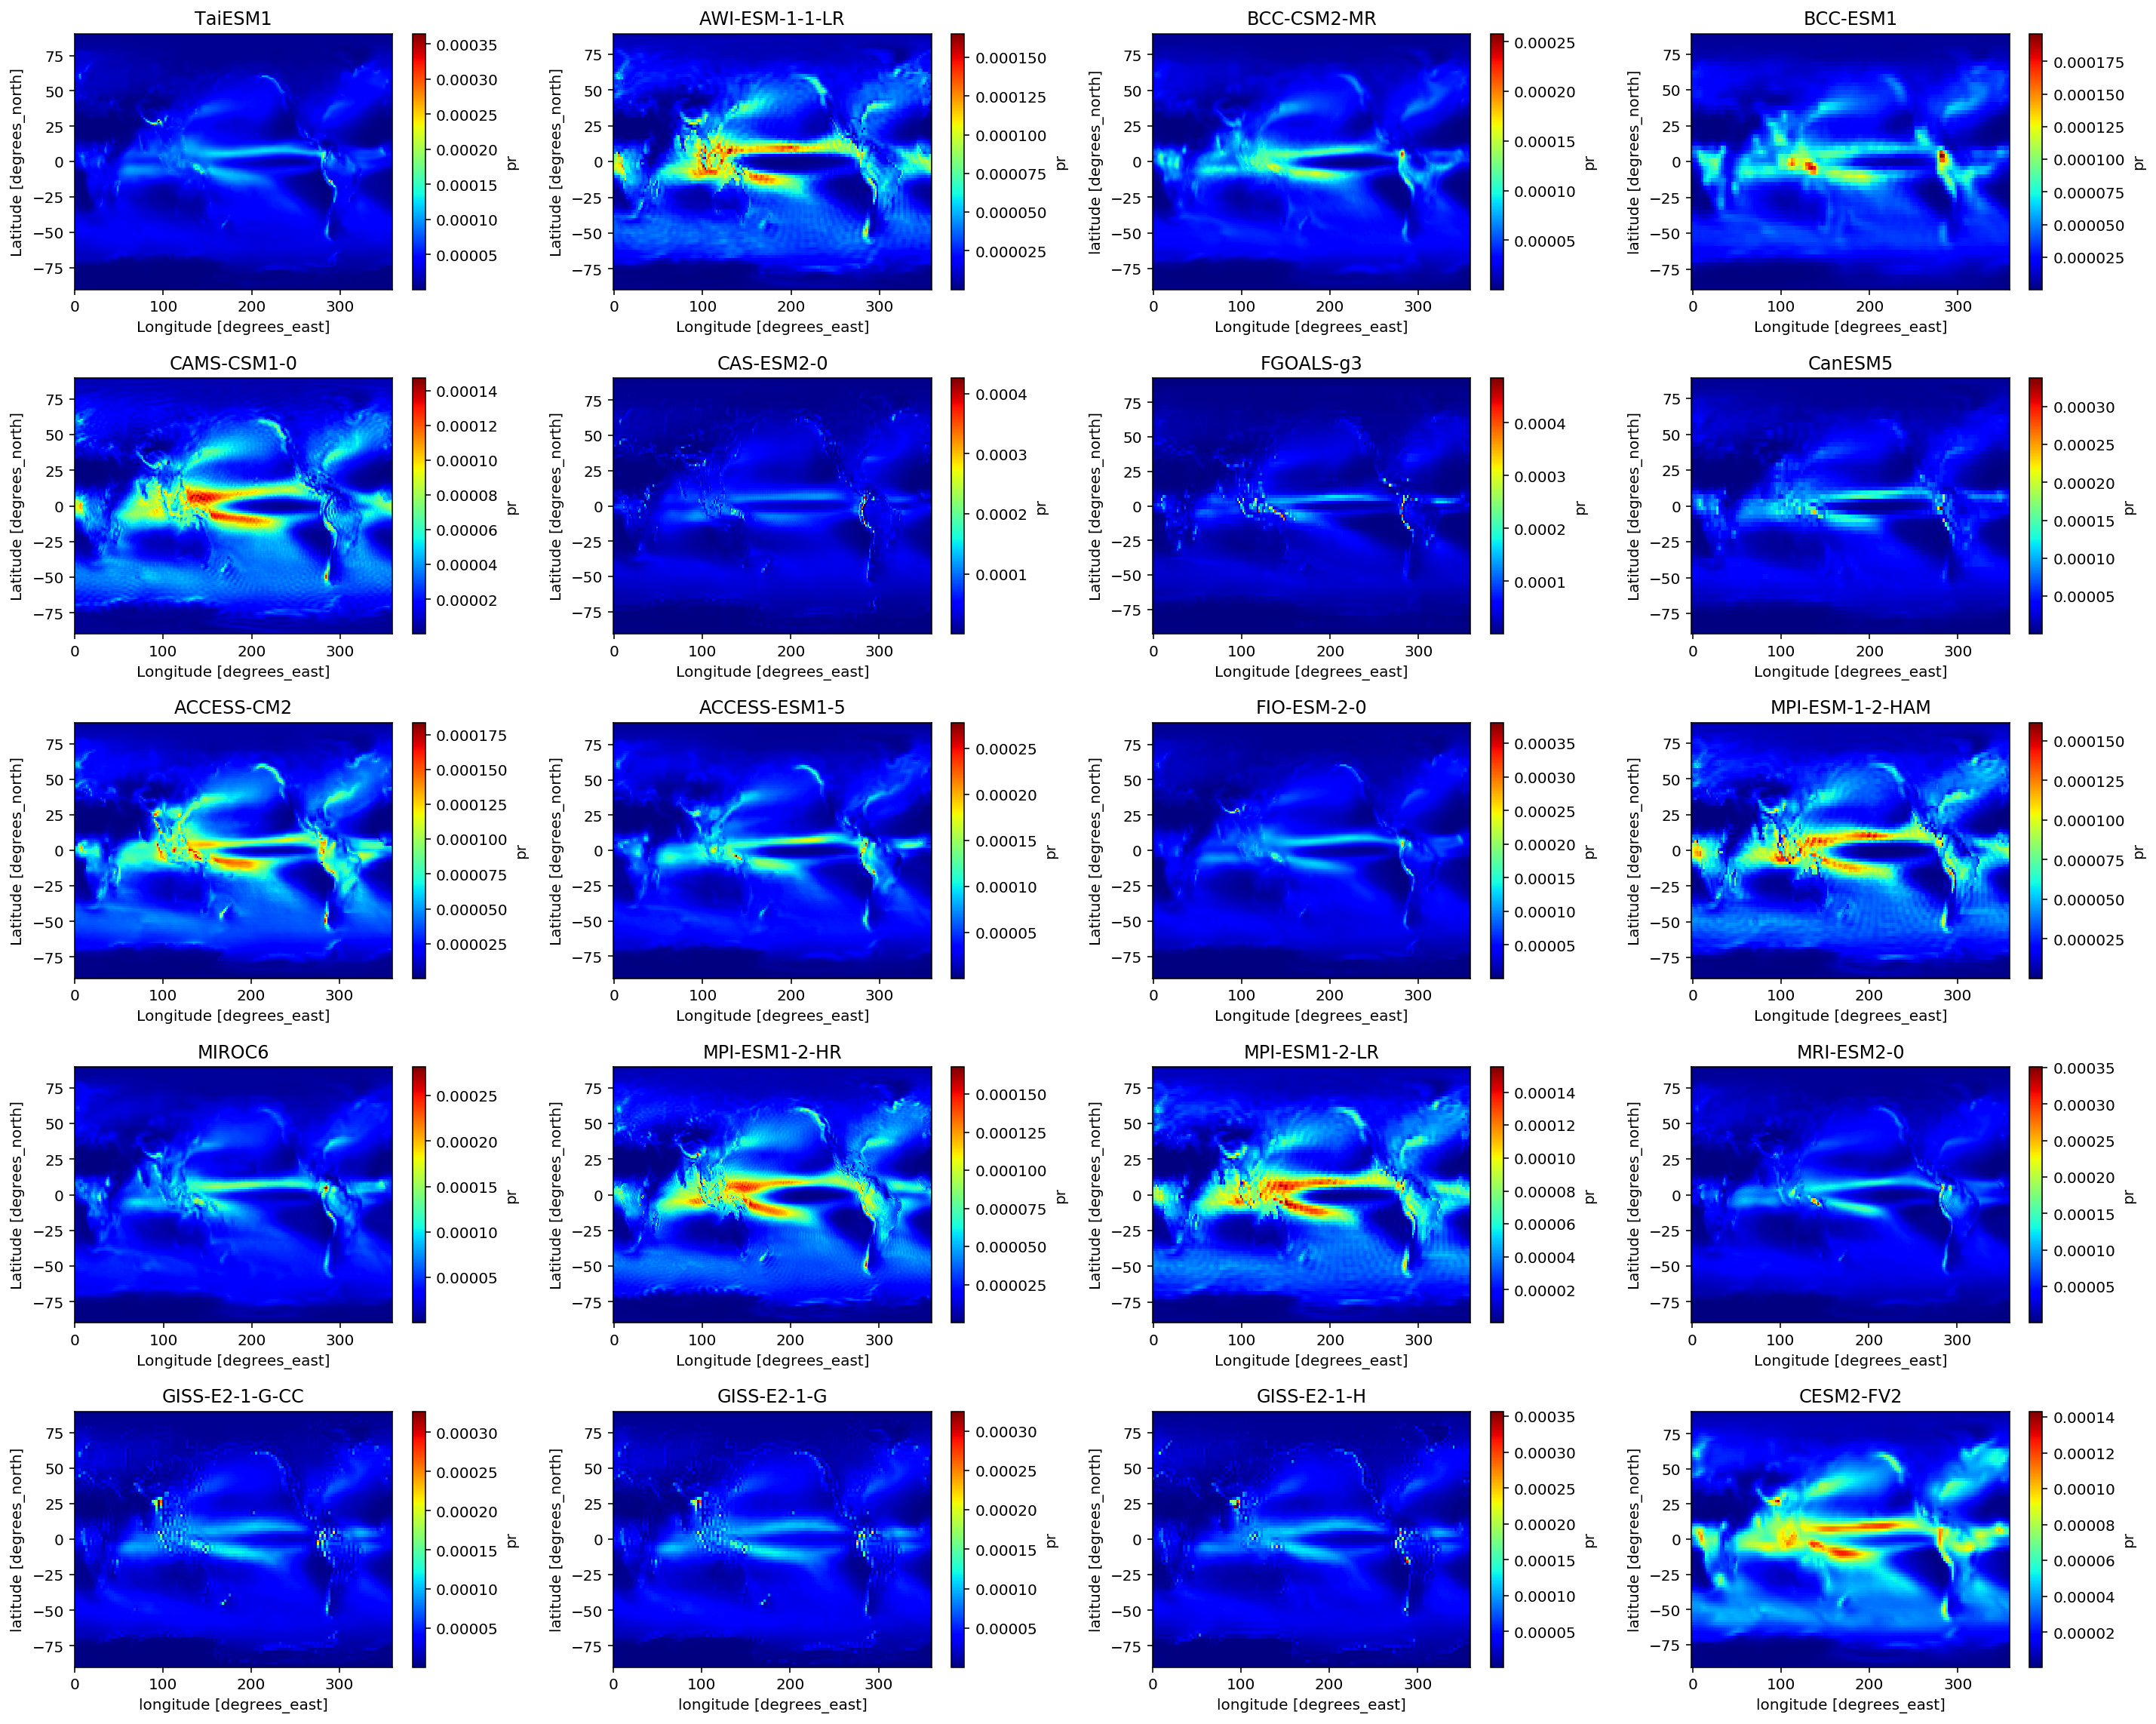

In [9]:
Plot_df = df_pr_mon

plt_cmap = 'jet'
year_start=1980
year_end=2000
Plot_var = 'pr'

Plot_source_ids = list(Plot_df['source_id'])

fig=plt.figure(figsize=(20,16))
for ii in tqdm(range(20)):
    ax = fig.add_subplot(5,4,ii+1)
    ds_plot = func_load_data(Plot_df, Plot_source_ids[ii]).sel(time=slice(str(year_start), str(year_end)))

    try:
        ds_plot[Plot_var].mean(axis=0).plot(cmap=plt_cmap)
    except:
        pass
    
    plt.title(source_ids[ii])

plt.tight_layout()

distributed.utils_perf - INFO - full garbage collection released 26.12 MB from 80305 reference cycles (threshold: 10.00 MB)


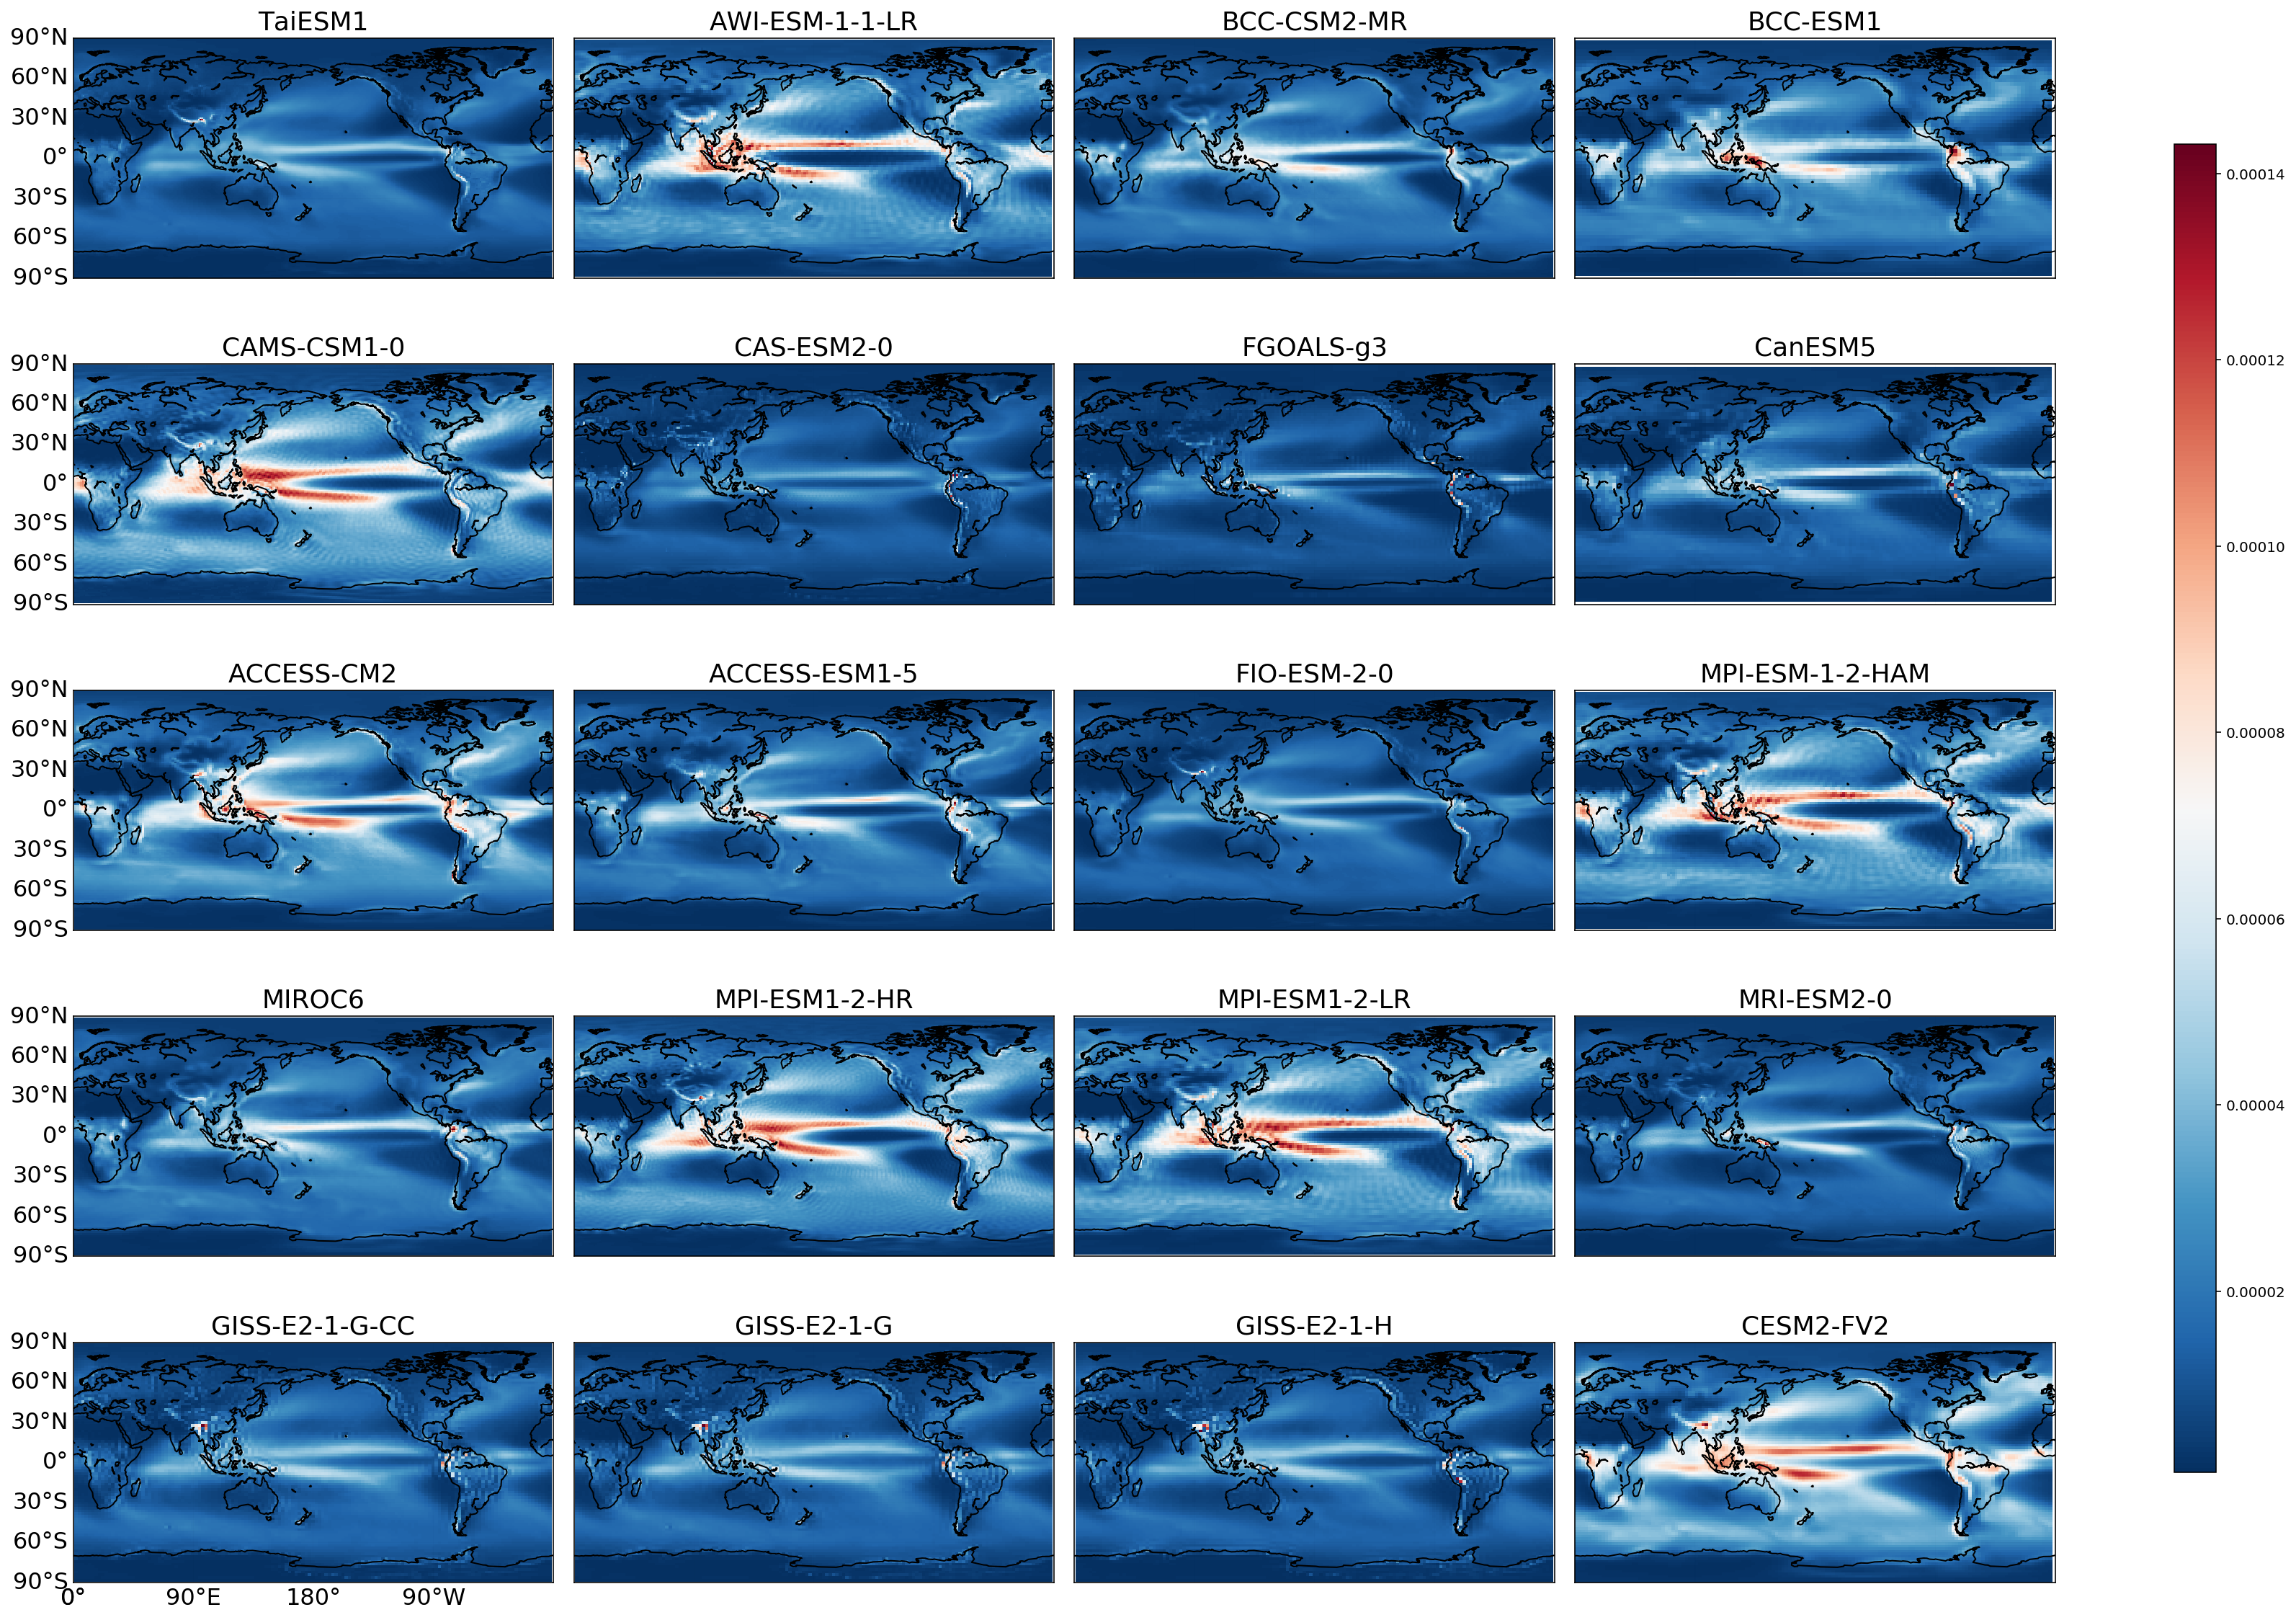

In [10]:
Plot_df = df_pr_mon
Plot_source_ids = list(Plot_df['source_id'])

Plt_cmap = plt.cm.RdBu_r
year_start=1980
year_end=2000
Plot_var = 'pr'

n_t=len(Plot_df)
n_c = 4; n_r = 5
P_proj='cyl'; P_lon0=210.; P_latN=90.; P_latS=-90.;

fig, axes = plt.subplots(nrows=n_c, ncols=n_r, sharex=True, sharey=True,figsize=(20, 16))
for ii in tqdm(range(20)):  
    
    ds_plot = func_load_data(Plot_df, Plot_source_ids[ii]).sel(time=slice(str(year_start), str(year_end)))
    Plot_Var = np.nanmean(ds_plot[Plot_var],axis=0)

    try:
        Plot_Lon, Plot_Lat = np.meshgrid(ds_plot.lon, ds_plot.lat)
    except:
        pass
    try:
        Plot_Lon, Plot_Lat = np.meshgrid(ds_plot.longitude, ds_plot.latitude)
    except:
        pass
    
    ax = plt.subplot(n_r,n_c,ii+1)   
    im = plt.pcolormesh(Plot_Lon, Plot_Lat, Plot_Var, cmap=Plt_cmap)
    ax.set_title(str(Plot_source_ids[ii]),fontsize= 18) 
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    m = Basemap( projection=P_proj, lon_0=210., llcrnrlon=0., llcrnrlat=P_latS, urcrnrlon=360., urcrnrlat=P_latN)

    if ii == (n_c*(n_r-1)): # Adds longitude ranges only to the last subplots that appear at the bottom of plot
        m.drawparallels(np.arange(P_latS, P_latN+0.001, 30.),labels=[True,False,False,False], linewidth=0.01, color='k', fontsize=16) # labels = [left,right,top,bottom] # Latitutes
        m.drawmeridians(np.arange(0,360,90.),labels=[False,False,False,True], linewidth=0.01, color='k', fontsize=16) # labels = [left,right,top,bottom] # Longitudes    
        m.drawcoastlines(linewidth=1.0, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
    elif ii==0 or ii==n_c or ii==n_c*2 or ii==n_c*3 or ii==n_c*4 or ii==n_c*5 or ii==n_c*6 or ii==n_c*7 or ii==n_c*8:
        m.drawparallels(np.arange(P_latS, P_latN+0.001, 30.),labels=[True,False,False,False], linewidth=0.01, color='k', fontsize=16) # labels = [left,right,top,bottom] # Latitutes
        m.drawcoastlines(linewidth=1.0, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
    elif ii >= n_t-n_c and ii != (n_c*(n_r-1)): # Adds longitude ranges only to the last subplots that appear at the bottom of plot
        m.drawmeridians(np.arange(0,360,90.),labels=[False,False,False,True], linewidth=0.01, color='k', fontsize=16) # labels = [left,right,top,bottom] # Longitudes
        m.drawcoastlines(linewidth=1.0, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
    else:
        m.drawparallels(np.arange(P_latS, P_latN+0.001, 30.),labels=[False,False,False,False], linewidth=0.01, color='k', fontsize=16) # labels = [left,right,top,bottom] # Latitutes
        m.drawmeridians(np.arange(0,360,90.),labels=[False,False,False,False], linewidth=0.01, color='k', fontsize=16) # labels = [left,right,top,bottom] # Longitudes
        m.drawcoastlines(linewidth=1.0, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)

#fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, wspace=0.15, hspace=0.15) # the amount of height/width reserved for space between subplots
plt.tight_layout()
cb_ax = fig.add_axes([1.05, 0.1, 0.02, 0.8])  # [right,bottom,width,height] 
cbar = fig.colorbar(im, cax=cb_ax)
#plt.suptitle('Average precipitation rate', fontsize=18)  


In [11]:
def func_latlon_regrid_eq(lat_n_regrid, lon_n_regrid, lat_min_regrid, lat_max_regrid, lon_min_regrid, lon_max_regrid): 
    #### Latitude Bounds ####
    Lat_regrid_1D= np.zeros ((lat_n_regrid+1));
    Lat_bound_regrid = np.zeros ((lat_n_regrid+1,2)); Lat_bound_regrid[0,0]=-90;  Lat_bound_regrid[0,1]=Lat_bound_regrid[0,0] + ( (180/lat_n_regrid) /2 ); Lat_regrid_1D[0]=(Lat_bound_regrid[0,0]+Lat_bound_regrid[0,1])/2
    for ii in range(1,lat_n_regrid+1):
        Lat_bound_regrid[ii,0]=Lat_bound_regrid[ii-1,1]
        Lat_bound_regrid[ii,1]=Lat_bound_regrid[ii,0] +  (180/lat_n_regrid)
        Lat_regrid_1D[ii]=(Lat_bound_regrid[ii,0]+Lat_bound_regrid[ii,1])/2
    Lat_bound_regrid[-1,1]=90;  Lat_regrid_1D[-1]=(Lat_bound_regrid[-1,0]+Lat_bound_regrid[-1,1])/2
    #### Longitude Bounds ####
    Lon_regrid_1D= np.zeros ((lon_n_regrid));
    Lon_bound_regrid = np.zeros ((lon_n_regrid,2)); Lon_bound_regrid[0,0]=0;  Lon_bound_regrid[0,1]=Lon_bound_regrid[0,0] + (360/lon_n_regrid); Lon_regrid_1D[0]=(Lon_bound_regrid[0,0]+Lon_bound_regrid[0,1])/2
    for ii in range(1,lon_n_regrid):
        Lon_bound_regrid[ii,0]=Lon_bound_regrid[ii-1,1]
        Lon_bound_regrid[ii,1]=Lon_bound_regrid[ii,0] +  (360/lon_n_regrid)
        Lon_regrid_1D[ii]=(Lon_bound_regrid[ii,0]+Lon_bound_regrid[ii,1])/2
    
    return Lat_regrid_1D, Lon_regrid_1D, Lat_bound_regrid, Lon_bound_regrid


def func_regrid(Data_orig, Lat_orig, Lon_orig, Lat_regrid_2D, Lon_regrid_2D):    
    
    Lon_orig[Lon_orig < 0] +=360
    if np.ndim(Lon_orig)==1: # If the GCM grid is not curvlinear
        Lon_orig,Lat_orig=np.meshgrid(Lon_orig, Lat_orig)
        
    lon_vec = np.asarray(Lon_orig)
    lat_vec = np.asarray(Lat_orig)
    lon_vec = lon_vec.flatten()
    lat_vec = lat_vec.flatten()
    coords=np.squeeze(np.dstack((lon_vec,lat_vec)))

    Data_orig=np.squeeze(Data_orig)
    if Data_orig.ndim==2:#this is for 2d regridding
        data_vec = np.asarray(Data_orig)
        if np.ndim(data_vec)>1:
            data_vec = data_vec.flatten()
        Data_regrid = griddata(coords, data_vec, (Lon_regrid_2D, Lat_regrid_2D), method='nearest')
        return np.asarray(Data_regrid)
    if Data_orig.ndim==3:#this is for 3d regridding
        Data_regrid=[]
        for d in range(len(Data_orig)):
            z = np.asarray(Data_orig[d,:,:])
            if np.ndim(z)>1:
                z = z.flatten()
            zi = griddata(coords, z, (Lon_regrid_2D, Lat_regrid_2D), method='nearest')
            Data_regrid.append(zi)
        return np.asarray(Data_regrid)
    
def func_oceanlandmask(Lat_regrid_2D, Lon_regrid_2D):
    lat_n_regrid, lon_n_regrid =Lat_regrid_2D.shape[0], Lat_regrid_2D.shape[1]
    Ocean_Land_mask = np.empty ((lat_n_regrid, lon_n_regrid)) * np.nan
    ocean_mask= maskoceans(Lon_regrid_2D-180, Lat_regrid_2D, Ocean_Land_mask)
    for ii in range(lat_n_regrid):
        for jj in range(lon_n_regrid):
            if np.ma.is_masked(ocean_mask[ii,jj]):
                Ocean_Land_mask[ii,jj]=1 # Land_Ocean_mask=1 means grid cell is ocean (not on land)
            else:
                Ocean_Land_mask[ii,jj]=0 # Land_Ocean_mask=0 means grid cell is land
    land_mask2 = copy.deepcopy ( Ocean_Land_mask ) # The created land_mask's longitude is from -180-180 - following lines transfer it to 0-360
    Ocean_Land_mask = np.empty((Lat_regrid_2D.shape[0], Lat_regrid_2D.shape[1])) * np.nan
    Ocean_Land_mask[:,0:int(Ocean_Land_mask.shape[1]/2)]=land_mask2[:,int(Ocean_Land_mask.shape[1]/2):]
    Ocean_Land_mask[:,int(Ocean_Land_mask.shape[1]/2):]=land_mask2[:,0:int(Ocean_Land_mask.shape[1]/2)]
    
    return Ocean_Land_mask # 1= ocean, 0= land

## Regridding calculations
Creating new coordinate grid (1degree by 1 degree) to be used for regridding model data

In [12]:
lat_n_regrid, lon_n_regrid = 180, 360 # Number of Lat and Lon elements in the regridded data
lon_min_regrid, lon_max_regrid = 0, 360 # Min and Max value of Lon in the regridded data
lat_min_regrid, lat_max_regrid = -90, 90 # Min and Max value of Lat in the regridded data

Lat_regrid_1D, Lon_regrid_1D, Lat_bound_regrid, Lon_bound_regrid = func_latlon_regrid_eq(lat_n_regrid, lon_n_regrid, lat_min_regrid, lat_max_regrid, lon_min_regrid, lon_max_regrid)
Lon_regrid_2D, Lat_regrid_2D = np.meshgrid(Lon_regrid_1D, Lat_regrid_1D)

Ocean_Land_mask = func_oceanlandmask(Lat_regrid_2D, Lon_regrid_2D) # 1= ocean, 0= land

In [13]:
def func_load_ds_uri(uri):
    """
    Load data for given uri
    """
    gcs = gcsfs.GCSFileSystem(token='anon') # GCSFS will attempt to use your default gcloud credentials
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [14]:
GCM = 'GFDL-CM4'
year_start=1
year_end=50

## Plotting Sea Surface Temperature average


In [15]:
uri_tos='gs://cmip6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Omon/tos/gr/'
ds_tos = func_load_ds_uri(uri_tos)
ds_tos = ds_tos.isel(time=slice(year_start-1, year_end*12))

In [16]:
yrs_no = np.int(len(ds_tos.time)/12)
Lon_orig=ds_tos.lon.values
Lat_orig=ds_tos.lat.values

Airtemp_final=[]
for t in tqdm(range(yrs_no)):
    ds_tos_extracted=ds_tos.tos.isel(time= slice(12*t,12*t+11) ).values
    data=np.squeeze(ds_tos_extracted)
    data=np.mean(data, axis=0)
    data_i = func_regrid(data, Lat_orig, Lon_orig, Lat_regrid_2D, Lon_regrid_2D)
    data_i[np.abs(data_i)>1e16]=np.nan # converting 1e+20 to nan
    
    Airtemp_final.append(data_i)

Airtemp_final=np.asarray(Airtemp_final)

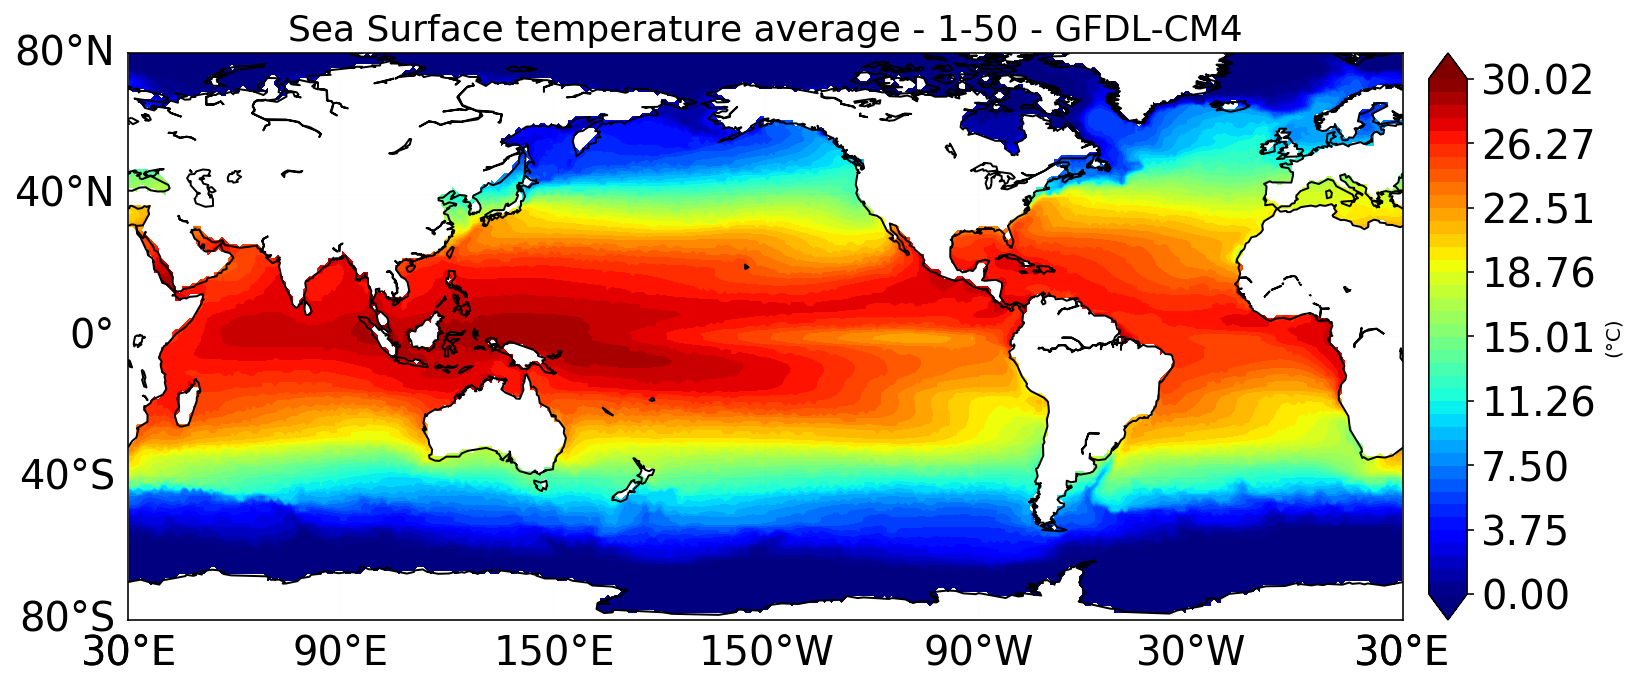

In [17]:
Plot_Var = np.nanmean(Airtemp_final,axis=0)

cmap_limit=np.nanmax(np.abs( np.nanpercentile(Plot_Var, 99.99)))
Plot_range=np.linspace(0,cmap_limit,41)
Plot_unit='(°C)'; Plot_title= 'Sea Surface temperature average - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM)

fig=plt.figure()
m = Basemap( projection='cyl', lon_0=210., llcrnrlon=210-180, llcrnrlat=-80., urcrnrlon=210.+180, urcrnrlat=80.)
m.drawparallels(np.arange(-80., 80.+0.001, 40.),labels=[True,False,False,False], linewidth=0.01, color='k', fontsize=20) # labels = [left,right,top,bottom] # Latitutes
m.drawmeridians(np.arange(210.-180,210.+180,60.),labels=[False,False,False,True], linewidth=0.01, color='k', fontsize=20) # labels = [left,right,top,bottom] # Longitudes        
m.drawcoastlines(linewidth=1.0, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
im=m.contourf(Lon_regrid_2D, Lat_regrid_2D, Plot_Var,Plot_range,latlon=True, cmap=plt.cm.jet, extend='both')
cbar = m.colorbar(im,"right", size="3%", pad="2%")
cbar.ax.tick_params(labelsize=20) 
cbar.set_label(Plot_unit)
plt.title(Plot_title, fontsize=18)
mng = plt.get_current_fig_manager()
#fig.savefig(dir_figs+'Wind_Tau_Y_'+str(GCM)+'.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

Text(0.5, 1.0, 'Sea Surface temperature average [C] - 1-50 - GFDL-CM4')

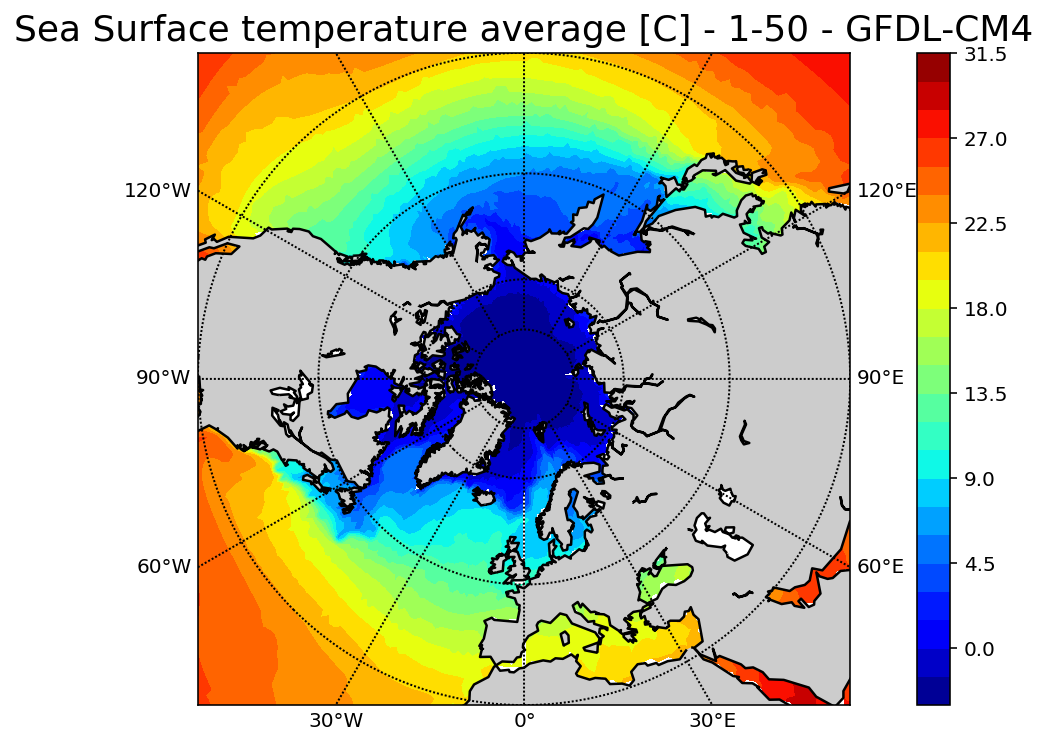

In [18]:
Plot_Var = np.nanmean(Airtemp_final,axis=0)

fig=plt.figure()
m = Basemap( projection='npstere',lon_0=0,boundinglat=30)
m.drawcoastlines(linewidth=1.25)
m.fillcontinents(color='0.8')
m.drawparallels(np.arange(-90,90,20), labels=[1,1,0,1])
m.drawmeridians(np.arange(0,360,30), labels=[1,1,0,1])
im=m.contourf(Lon_regrid_2D, Lat_regrid_2D, Plot_Var,30,latlon=True, cmap=plt.cm.jet)
plt.colorbar(im)
plt.title('Sea Surface temperature average [C] - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM), fontsize=18)
#fig.savefig(dir_figs+str(GCM)+'_average_MLD_LAB.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

## Westerlies and Trades Winds Calculations


In [19]:
## Calculating Wind Stress in X direction
df_plt = df[(df.variable_id == 'tauuo') & (df.experiment_id == 'piControl')& (df.source_id=='GFDL-CM4')]
run_counts = df_plt.groupby(['source_id', 'experiment_id'])['zstore'].count()
uri_tauuo = df_plt[(df_plt.source_id == GCM)].zstore.values[0]
ds_tauuo = func_load_ds_uri(uri_tauuo)

ds_tauuo = ds_tauuo.isel(time=slice(year_start-1, year_end*12))

In [20]:
Lon_orig=ds_tauuo.lon.values
Lat_orig=ds_tauuo.lat.values    

Lon_orig = np.array(Lon_orig).copy() # To solve the issue with imuutability of the variable (ValueError: assignment destination is read-only)
Lat_orig = np.array(Lat_orig).copy()

In [21]:
yrs_no = np.int(len(ds_tauuo.time)/12)
Tau_X =[]
for t in tqdm(range(yrs_no)):
    ds_tauuo_extracted=ds_tauuo.tauuo.isel(time= slice(12*t,12*t+11) ).values
    data=np.squeeze(ds_tauuo_extracted)
    data=np.mean(data, axis=0)
    data_i = func_regrid(data, Lat_orig, Lon_orig, Lat_regrid_2D, Lon_regrid_2D)
    data_i[np.abs(data_i)>1e16]=np.nan # converting 1e+20 to nan
    
    Tau_X .append(data_i)
Tau_X = np.asarray(Tau_X)

In [22]:
## Calculating Wind Stress in Y direction
df_plt = df[(df.variable_id == 'tauvo') & (df.experiment_id == 'piControl')& (df.source_id=='GFDL-CM4')]
run_counts = df_plt.groupby(['source_id', 'experiment_id'])['zstore'].count()
uri_tauvo = df_plt[(df_plt.source_id == GCM)].zstore.values[0]
ds_tauvo = func_load_ds_uri(uri_tauvo)

ds_tauvo = ds_tauvo.isel(time=slice(year_start-1, year_end*12))

In [23]:
yrs_no = np.int(len(ds_tauvo.time)/12)
Tau_Y =[]
for t in tqdm(range(yrs_no)):
    ds_tauvo_extracted=ds_tauvo.tauvo.isel(time= slice(12*t,12*t+11) ).values
    data=np.squeeze(ds_tauvo_extracted)
    data=np.mean(data, axis=0)
    data_i = func_regrid(data, Lat_orig, Lon_orig, Lat_regrid_2D, Lon_regrid_2D)
    data_i[np.abs(data_i)>1e16]=np.nan # converting 1e+20 to nan
    
    Tau_Y .append(data_i)
Tau_Y = np.asarray(Tau_Y)

In [24]:
## Calculating Curl of (Wind/f) (Ekman upwelling)
Wind_Curl_f = np.zeros(( Tau_X.shape[0], Tau_X.shape[1], Tau_X.shape[2])) # Wind_Crul / f # f = coriolis parameter = 2Wsin(LAT) , W = 7.292E-5 rad/s

for tt in tqdm(range (0,Tau_X.shape[0])): 
    for ii in range (1,Tau_X.shape[1]-1):
        if np.absolute( Lat_regrid_2D[ii,0] ) >= 5: # Only calulate for Lats > 5N and Lats < 5S, to avoid infinit numbers in equator where f is zero
            for jj in range (1,Tau_X.shape[2]-1): # Wind_Curl = ( D_Tau_Y / D_X ) - ( D_Tau_X / D_Y ) # D_X = (Lon_1 - Lon_2) * COS(Lat) 
                Wind_Curl_f[tt,ii,jj] = (  ( ( Tau_Y[tt, ii,jj+1] - Tau_Y[tt, ii,jj-1] ) / ( 2*7.292E-5 *  math.sin(math.radians( ( Lat_regrid_2D[ii,jj]))) ) ) /  np.absolute(  ( ( Lon_regrid_2D[ii,jj+1] -  Lon_regrid_2D[ii,jj-1] ) * 111321  *  math.cos(math.radians( ( Lat_regrid_2D[ii,jj])))   )  )     )   -   (  ( ( Tau_X[tt, ii+1,jj] - Tau_X[tt, ii-1,jj] ) / ( 2*7.292E-5 *  math.sin(math.radians( ( Lat_regrid_2D[ii,jj]))) ) ) / np.absolute( ( ( Lat_regrid_2D[ii+1,jj] -  Lat_regrid_2D[ii-1,jj] ) * 111321 ) )  )

            Wind_Curl_f[tt,ii,0] = (  ( ( Tau_Y[tt, ii,1] - Tau_Y[tt, ii,-1] ) / ( 2*7.292E-5 *  math.sin(math.radians( ( Lat_regrid_2D[ii,0]))) ) ) /  np.absolute(  ( ( Lon_regrid_2D[ii,1] -  Lon_regrid_2D[ii,-1] ) * 111321  *  math.cos(math.radians( ( Lat_regrid_2D[ii,0])))   )  )     )   -   (  ( ( Tau_X[tt, ii+1,jj] - Tau_X[tt, ii-1,0] ) / ( 2*7.292E-5 *  math.sin(math.radians( ( Lat_regrid_2D[ii,0]))) ) ) / np.absolute( ( ( Lat_regrid_2D[ii+1,0] -  Lat_regrid_2D[ii-1,0] ) * 111321 ) )  )
            Wind_Curl_f[tt,ii,-1] = (  ( ( Tau_Y[tt, ii,0] - Tau_Y[tt, ii,-2] ) / ( 2*7.292E-5 *  math.sin(math.radians( ( Lat_regrid_2D[ii,-1]))) ) ) /  np.absolute(  ( ( Lon_regrid_2D[ii,0] -  Lon_regrid_2D[ii,-2] ) * 111321  *  math.cos(math.radians( ( Lat_regrid_2D[ii,-1])))   )  )     )   -   (  ( ( Tau_X[tt, ii+1,-1] - Tau_X[tt, ii-1,-1] ) / ( 2*7.292E-5 *  math.sin(math.radians( ( Lat_regrid_2D[ii,-1]))) ) ) / np.absolute( ( ( Lat_regrid_2D[ii+1,-1] -  Lat_regrid_2D[ii-1,-1] ) * 111321 ) )  )

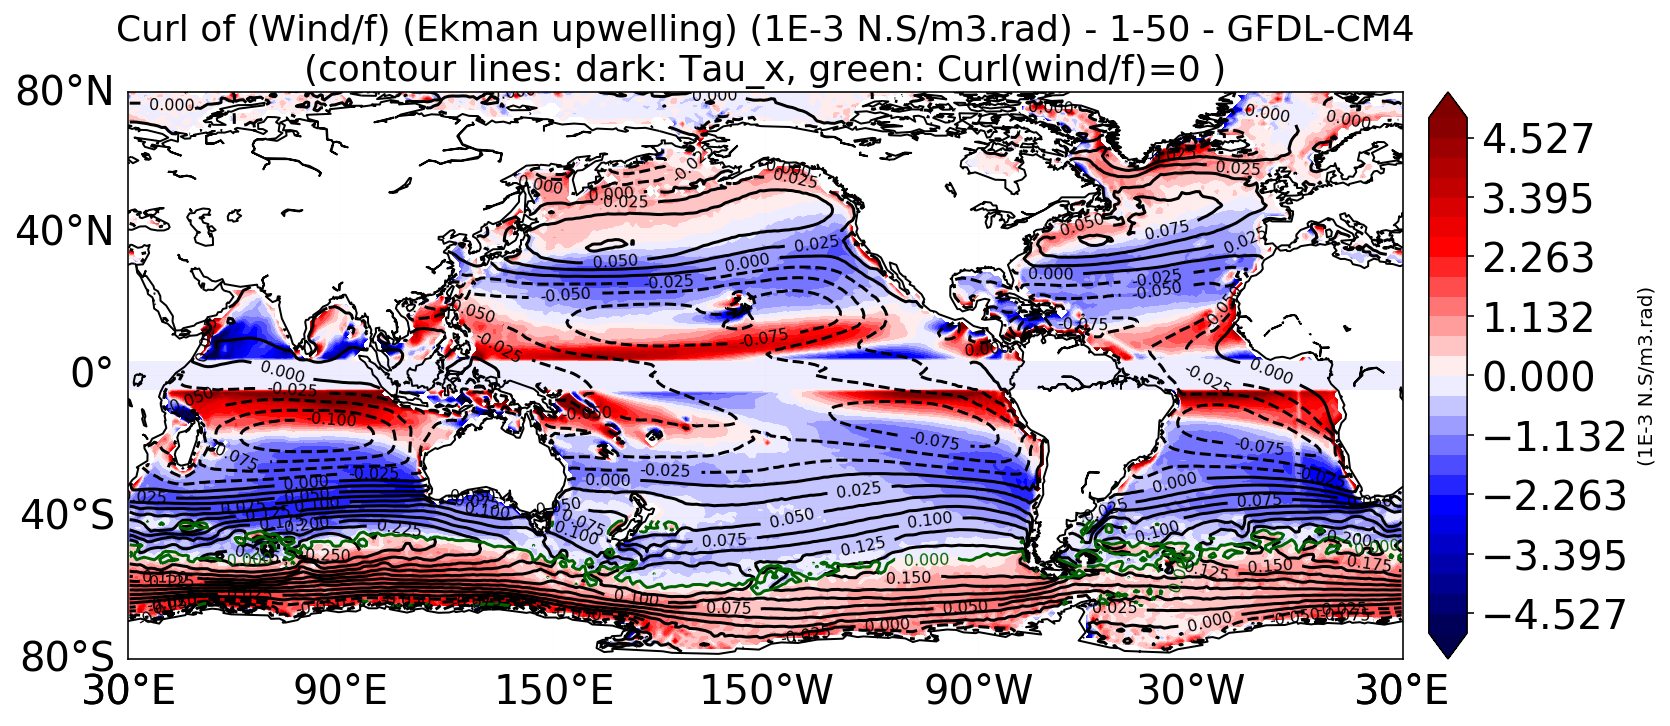

In [25]:
Plot_Var = np.nanmean(Wind_Curl_f,axis=0) * 1E3
Plot_Var2 = np.nanmean(Tau_X,axis=0)
Plot_Var2 [ Ocean_Land_mask==0 ]=np.nan # masking over land, so grid cells that fall on land area (value=0) will be deleted

cmap_limit=np.nanmax(np.abs( np.nanpercentile(Plot_Var, 99)))
Plot_range=np.linspace(-cmap_limit,cmap_limit,27)
Plot_unit='(1E-3 N.S/m3.rad)'; Plot_title= 'Curl of (Wind/f) (Ekman upwelling) (1E-3 N.S/m3.rad) - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM)+'\n(contour lines: dark: Tau_x, green: Curl(wind/f)=0 )'

fig=plt.figure()
m = Basemap( projection='cyl', lon_0=210., llcrnrlon=210-180, llcrnrlat=-80., urcrnrlon=210.+180, urcrnrlat=80.)
m.drawparallels(np.arange(-80., 80.+0.001, 40.),labels=[True,False,False,False], linewidth=0.01, color='k', fontsize=20) # labels = [left,right,top,bottom] # Latitutes
m.drawmeridians(np.arange(210.-180,210.+180,60.),labels=[False,False,False,True], linewidth=0.01, color='k', fontsize=20) # labels = [left,right,top,bottom] # Longitudes        
m.drawcoastlines(linewidth=1.0, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
im=m.contourf(Lon_regrid_2D, Lat_regrid_2D, Plot_Var,Plot_range,latlon=True, cmap=plt.cm.seismic, extend='both')
cbar = m.colorbar(im,"right", size="3%", pad="2%")
cbar.ax.tick_params(labelsize=20) 
cbar.set_label(Plot_unit)
plt.title(Plot_title, fontsize=18)
mng = plt.get_current_fig_manager()

im2=m.contour(Lon_regrid_2D, Lat_regrid_2D,Plot_Var2, 20, latlon=True, colors='k')
plt.clabel(im2, fontsize=8, inline=1)
im3=m.contour(Lon_regrid_2D[25:50,:], Lat_regrid_2D[25:50,:],Plot_Var[25:50,:], levels = [0], latlon=True, colors='darkgreen')
plt.clabel(im3, fontsize=8, inline=1)
plt.show()
#fig.savefig(dir_figs+'Wind_Curl_f_'+str(GCM)+'.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

## Atlantic Meridional Overturning Circulation (AMOC) calculation
AMOC is defined as the maximum of streamfunction over atlantic ocean at each latitude

In [26]:
def func_calc_Atl_Mask():
    ny, nx = 181, 360
    xmin, xmax = 0, 359
    ymin, ymax = -90, 90
    xi = np.linspace(xmin, xmax, nx)
    yi = np.linspace(ymin, ymax, ny)
    lon, lat = np.meshgrid(xi, yi)
    [i,j] = np.where(np.logical_or(
                       np.logical_or((lat<=12) & (lon>=0) & (20>=lon),(lat<=12) & (290<=lon)& (lon<=360)),#### SH indeces
                       np.logical_or((lat>12) & (lon>=0) & (20>=lon),(lat>12) & (270<=lon) & (lon<=360))))#### NH indeces####
    return [i,j]

def func_stream(ds_vo):
  
    depths=ds_vo.lev.values
    ### these are upper and lower depths of each cell in an ocean grid
    depths_b=ds_vo.lev_bnds.values
    ### calculate the depth of each cell in an ocean grid
    depths_r=depths_b[:,1]-depths_b[:,0]
    ### find timeindeces
    yrs_no = np.int(len(ds_vo.time)/12)
    
    Lon_orig=ds_vo.lon.values
    Lat_orig=ds_vo.lat.values    

    Lon_orig = np.array(Lon_orig).copy() # To solve the issue with imuutability of the variable (ValueError: assignment destination is read-only)
    Lat_orig = np.array(Lat_orig).copy()

    lat_n_regrid=180
    lon_n_regrid=360
    Lat_regrid_1D, Lon_regrid_1D, Lat_bound_regrid, Lon_bound_regrid = func_latlon_regrid_eq(lat_n_regrid, lon_n_regrid, -90, 90, 0, 360)
    lon, lat = np.meshgrid(Lon_regrid_1D, Lat_regrid_1D)
    
    mask_atl=func_calc_Atl_Mask()           
        
    ### Averaging velocities over the year for monthly data
    for t in tqdm(range(yrs_no)):
        data_vo_extracted=ds_vo.vo.isel(time= slice(12*t,12*t+11) ).values
        data=np.squeeze(data_vo_extracted)
        data=np.mean(data, axis=0)
        
        data_i = func_regrid(data, Lat_orig, Lon_orig, lat, lon)
        data_i[np.abs(data_i)>1e16]=np.nan # converting 1e+20 to nan

        if t==0: 
            data_depth=np.full([len(lon),len(lon[0])], np.nan)
            data_depth_ranges=np.full([len(data_i),len(data_i[0]),len(data_i[0][0])], np.nan)
        [ii,jj] = mask_atl
        for k in range(len(ii)):
            #### I calculate the depth by looking how many nans is in the depth column
            if sum(~np.isnan(data_i[:,ii[k],jj[k]]))>0:
                if t==0:
                    data_depth[ii[k],jj[k]]=depths[sum(~np.isnan(data_i[:,ii[k],jj[k]]))-1]
                    for l in range(sum(~np.isnan(data_i[:,ii[k],jj[k]]))):
                        data_depth_ranges[l,ii[k],jj[k]]=depths_r[l]        
        
        #### calculating volume transport
        #### first multiplying by 111km*cos(lat)
        mul_by_lat=data_i*(np.cos(np.deg2rad(lat))*111321) # V_y * dX [Unit: m/s * m]
        #### second multiplying by depth
        transport=mul_by_lat*data_depth_ranges/1000000 # V_y * dX * dZ [Unit: m/s * m * m * 1e-6 = Sverdrup]
        #### calculating integral over dz
        transport_lon=np.nansum(transport,axis=2) # SUM(V_y * dX * dZ) over longitudes [Unit: m3/s * 1e-6 = Sverdrup]
        #### calculating cum integral over dz
        transport_lon_final.append(transport_lon) # SUM(V_y * dX * dZ) over longitudes, for all years
        
    transport_lon_final=np.asarray(transport_lon_final)
    
    return transport_lon_final

In [32]:
df_plt = df[(df.variable_id == 'vo') & (df.experiment_id == 'piControl')& (df.source_id=='GFDL-CM4')]
run_counts = df_plt.groupby(['source_id', 'experiment_id'])['zstore'].count()
uri_vo = df_plt[(df_plt.source_id == GCM)].zstore.values[0]
ds_vo = func_load_ds_uri(uri_vo)

ds_vo = ds_vo.isel(time=slice(year_start-1, year_end*12))

In [33]:
Transport_lon_final  = func_stream(ds_vo)

In [34]:
###################################################################
### Streamfunction calculations to be used for AMOC calculation ###
Stream_function=np.empty((Transport_lon_final.shape[0], Transport_lon_final.shape[1], Transport_lon_final.shape[2]))*np.nan # streamfunction
Stream_function[:,0,:]=Transport_lon_final[:,0,:]
for ii in range(1,Stream_function.shape[1]): # Depths
    Stream_function[:,ii,:]=Stream_function[:,ii-1,:]+Transport_lon_final[:,ii,:]

AMOC_max=np.nanmax(Stream_function, axis=1)

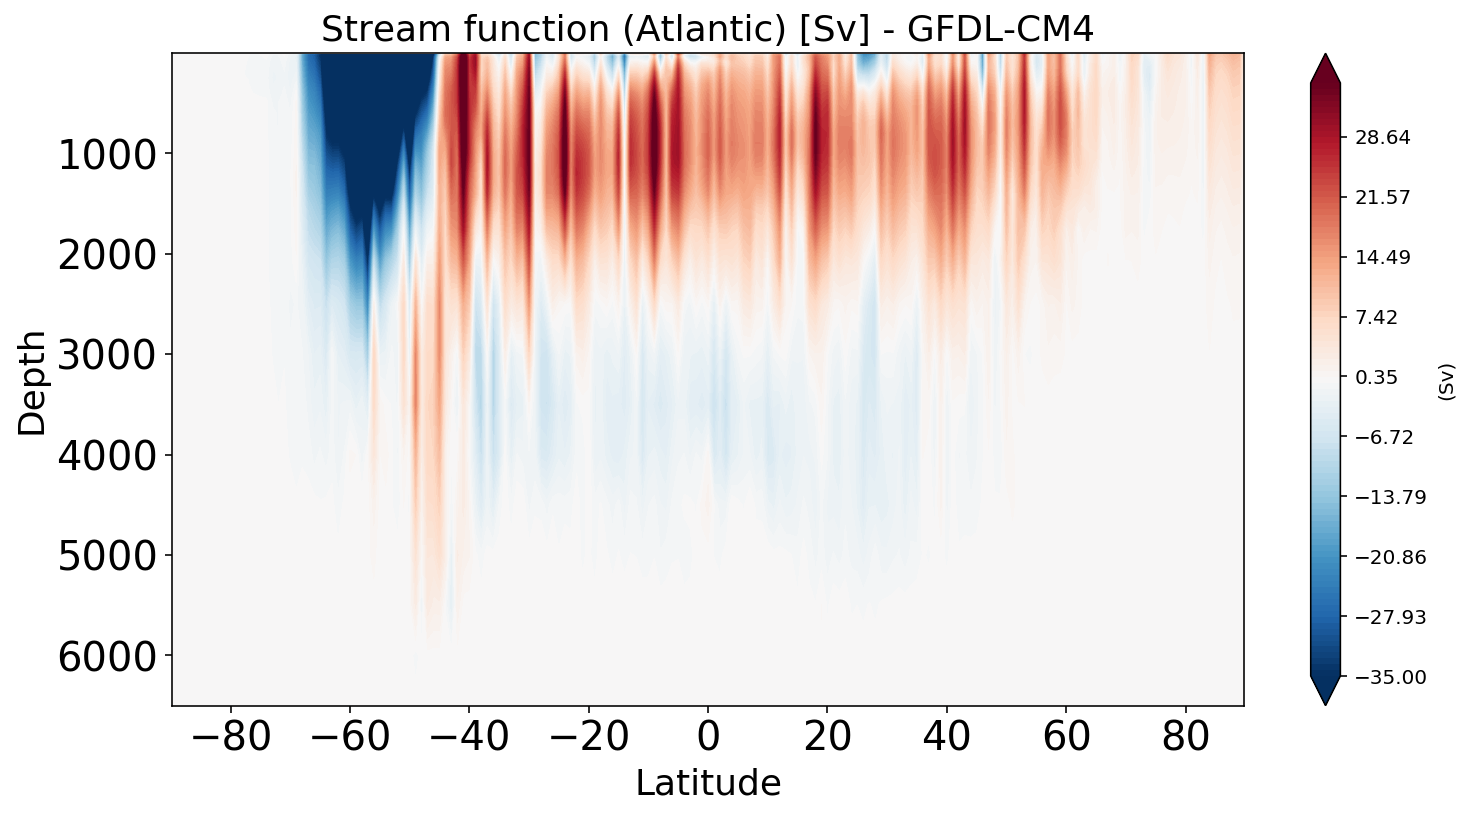

In [35]:
Depths=ds_vo.lev.values
levels=np.linspace(-35,35,100) 

fig=plt.figure()
im=plt.contourf(Lat_regrid_1D, Depths, Stream_function_ave, levels, cmap=plt.cm.RdBu_r, extend = 'both')
plt.gca().invert_yaxis()
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Depth', fontsize=18)
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.title('Stream function (Atlantic) [Sv] - '+str(GCM), fontsize=18)
cbar = plt.colorbar(im, extend='max')
cbar.set_label('(Sv)')
mng = plt.get_current_fig_manager()
#fig.savefig(dir_figs+str(GCM)+'_Stream_function_ave.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

# Power Spectral Density (PSD) calculation

In [36]:
#### Compute and plot PSD using welch method####
def plot_PSD_welch_conf(P_Var, P_fq, P_c_probability, P_rho, P_smooth, P_title, P_color, P_legend, P_legend_loc):
### P_c_probability= 0.95 or 0.05 or '-' = confidence interval levels, if the input is not a number then teh confidence intervals won't be plptted
### P_rho = 'yes' or 0.7 or '-' = Red noise significance line, if 'yes' then the Rho and line will be calculated, if P_rho is a number then it will be given as the Rho value, else NO Red noise significance line will be plotted
### P_smooth = 9 (should be even number) or '-' = Number of years for smoothing the PSD line and confidence intervals, if no number is given then NO smoothing will be applied
### P_Var= Plotting variable at X-axis, 1D(X) || P_title=Plot title || P_color=Plot line color || P_legend=Plot variable name to be shown in Plot Legend 
### P_fq=PSD Welch method's sampling frequency of the x time series in units of Hz (Defaults to 1.0) || P_legend_loc=location of legend, 'best' or 'lower left' or 'right' or 'center' or ...
#%% Example :

#P_Var=WS_index ; P_legend='WS Convection Index' ; P_color='r'
#P_title='Power Spectral Density - WS Convection Index with 95% confidence intervals - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM)
#fig=plt.figure()
#ff,PSD=plot_PSD_welch_conf(P_Var, 1, 0.95, 'yes', 9, P_title, P_color, P_legend, 'lower right')
#plt.ylim(1e-5,1e3) #;plt.xlim(1,500)
#fig.savefig(dir_figs+'name.png', format='png', dpi=300, transparent=True, bbox_inches='tight') 
### 
    from scipy.stats import chi2    
    from scipy import signal

    ff,PSD = signal.welch(P_Var,P_fq) # ff= Array of sample frequencies  ,  PSD = Pxx, Power spectral density or power spectrum of x (which is P_Var)
    X_var=np.linspace(1,len(P_Var)/2+1,len(P_Var)/2+1)
    X_var=ff**(-1); X_var=X_var
    
    if P_rho=='yes':
        Rho = np.nansum( (P_Var[:-1] - np.nanmean(P_Var,axis=0)) * (P_Var[1:] - np.nanmean(P_Var,axis=0)) ,axis=0) / np.nansum( (P_Var[:-1] - np.nanmean(P_Var,axis=0)) * (P_Var[:-1] - np.nanmean(P_Var,axis=0)) ,axis=0)
    elif type(P_rho)==float:
        Rho=P_rho # Rho is the memory parameter
    
    if type(P_smooth)==float or type(P_smooth)==int:
        P_smooth=np.int(P_smooth)
        v = 2*P_smooth # P is the number of estimates in welch function and also the degree of freedom.
        
        sm= np.int( (P_smooth-1)/2)
        P_smooth = np.int( (sm*2)+1 ) # P_smoothhs to be even number for centered smoothing; in case odd number was given, it's changed to an even number by subtracting 1
        PSD_m=copy.deepcopy(PSD) ## Smoothing the variable
        for ii in range(sm,PSD.shape[0]-sm+1):
            PSD_m[ii]=np.nanmean(PSD[ii-sm:ii+sm])
        
        PSD_m=PSD_m[sm:-sm]
        X_var_m=X_var[sm:-sm]
        P_legend=P_legend+' ('+str(np.int(P_smooth))+'yr smoothed)'
        
    else:
        v=2

        PSD_m=copy.deepcopy(PSD)
        X_var_m=copy.deepcopy(X_var)
        
    if type(P_c_probability)==float:
        if P_c_probability < 0.5:
            P_c_probability=1-P_c_probability # In case the P_c_probability is input 0.05 instead of 0.95 for example
        alfa = 1 - P_c_probability

    if P_rho=='yes' or type(P_rho)==float or type(P_rho)==int:
        if type(P_c_probability)!=float: # In case the P_c_probability is not given since confidence interval calculation is not necessary, but red noise significance line is needed
            alfa=0.05
            
        F_x_v = (1-Rho**2) / (1 + Rho**2 - 2*Rho*np.cos(2*np.pi*ff ) )  #  F_x_v is the power spectraum   
        F_x_v_star=np.float( np.real( np.nanmean(PSD,axis=0) / np.nanmean(F_x_v,axis=0) ) ) * F_x_v 
        Pr_alpha = (1/v) * F_x_v_star * np.float( chi2.ppf([1 - alfa], v) )
    
    plt.grid(True,which="both",ls="-", color='0.65')
    plt.loglog(X_var_m,PSD_m, color=P_color, label=P_legend)
    plt.legend(loc='best')
    plt.xlabel('Period (years)', fontsize=18)
    plt.ylabel('Spectral Density', fontsize=18) 
    plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
    #plt.gca().invert_xaxis()
    if type(P_c_probability)==float:
        Chi = chi2.ppf([1 - alfa / 2, alfa / 2], v)
        
        PSDc_lower = PSD_m * ( v / Chi[0] )
        PSDc_upper = PSD_m * ( v / Chi[1] ) 
        plt.loglog(X_var_m,PSDc_lower, color='g', ls='--', label=str(np.int( (1 - alfa) *100))+'% confidence intervals')
        plt.loglog(X_var_m,PSDc_upper, color='g', ls='--')
    if P_rho=='yes' or type(P_rho)==float or type(P_rho)==int:
        plt.loglog(X_var,Pr_alpha , color='b', ls='--', label=str(np.int( (1 - alfa) *100))+'% Red Noise Significance Level')
    plt.legend(prop={'size': 20}, loc=P_legend_loc, fancybox=True, framealpha=0.8)
    plt.title(P_title, fontsize=18) 
    #plt.show()
    mng = plt.get_current_fig_manager()
    #mng.window.showMaximized() # Maximizes the plot window to save figures in full
    return ff,PSD


In [37]:
AMOC_max_50S= AMOC_max[:,40] # AMOC at 50S # Max of streamfunction method
AMOC_max_30S= AMOC_max[:,60] # AMOC at 30S # Max of streamfunction method
AMOC_max_50N= AMOC_max[:,140] # AMOC at 50N # Max of streamfunction method
AMOC_max_30N= AMOC_max[:,120] # AMOC at 30N # Max of streamfunction method

AMOC_max_50S_norm=(AMOC_max_50S-np.nanmean(AMOC_max_50S))/np.std(AMOC_max_50S) # Normalized AMOC timeseries
AMOC_max_30S_norm=(AMOC_max_30S-np.nanmean(AMOC_max_30S))/np.std(AMOC_max_30S) # Normalized AMOC timeseries
AMOC_max_50N_norm=(AMOC_max_50N-np.nanmean(AMOC_max_50N))/np.std(AMOC_max_50N) # Normalized AMOC timeseries
AMOC_max_30N_norm=(AMOC_max_30N-np.nanmean(AMOC_max_30N))/np.std(AMOC_max_30N) # Normalized AMOC timeseries

(0.01, 100.0)

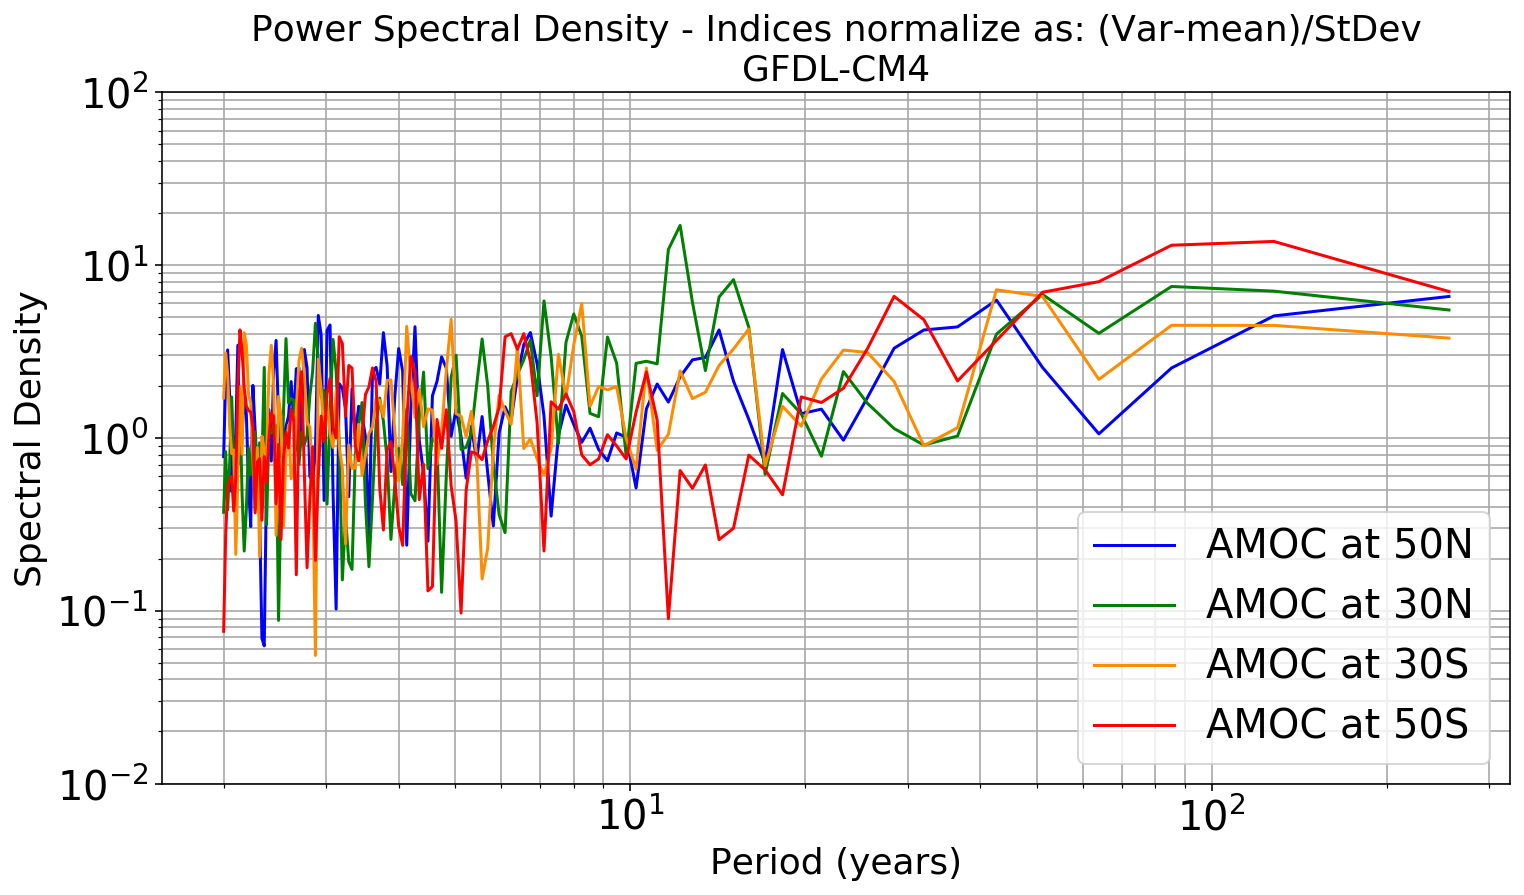

In [38]:
P_title='Power Spectral Density - Indices normalize as: (Var-mean)/StDev\n'+str(GCM)
fig=plt.figure(); ax = fig.add_axes([0.12,0.1,0.78,0.8]) # ax [left, bottom, width, height]
ff,PSD=plot_PSD_welch_conf(AMOC_max_50N_norm, 1, '-', '-', '-', P_title, 'b', 'AMOC at 50N', 'lower right')
ff,PSD=plot_PSD_welch_conf(AMOC_max_30N_norm, 1, '-', '-', '-', P_title, 'g', 'AMOC at 30N', 'lower right')
ff,PSD=plot_PSD_welch_conf(AMOC_max_30S_norm, 1, '-', '-', '-', P_title, 'darkorange', 'AMOC at 30S', 'lower right')
ff,PSD=plot_PSD_welch_conf(AMOC_max_50S_norm, 1, '-', '-', '-', P_title, 'r', 'AMOC at 50S', 'lower right')
plt.ylim(1e-2,1e2) #;plt.xlim(1,500)
#fig.savefig(dir_figs+str(GCM)+'_PSD_AMOC_Norm_1.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
